# Introduction

# Data preparation

## Load packages

In [1]:
%cd ../RADOM

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from plotting import *
from models.two_species import get_Y

/home/mffang/workspace/Poisson-regression/RADOM


In [78]:
import scanpy as sc
import scvelo as scv
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

In [ ]:
#!wget --directory-prefix=../data/ http://pklab.med.harvard.edu/velocyto/DentateGyrus/DentateGyrus.loom

In [65]:
adata = sc.read('../data/DentateGyrus.loom')
adata.var_names_make_unique
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 18213 × 27998
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [5]:
clusters = set(adata.obs['ClusterName'])
clusters

{'CA',
 'CA1-Sub',
 'CA2-3-4',
 'GlialProg',
 'Granule',
 'ImmAstro',
 'ImmGranule1',
 'ImmGranule2',
 'Nbl1',
 'Nbl2',
 'OPC',
 'RadialGlia',
 'RadialGlia2',
 'nIPC'}

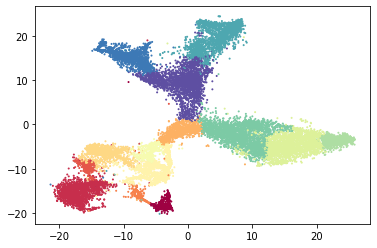

In [6]:
plt.scatter(adata.obs['TSNE1'],adata.obs['TSNE2'],c=adata.obs['Clusters'],s=1,cmap='Spectral_r');

**Check count numbers**

In [7]:
U_mean = adata.layers["unspliced"].toarray().mean(axis=0)
S_mean = adata.layers["spliced"].toarray().mean(axis=0)

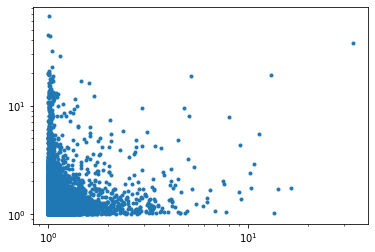

In [8]:
plt.loglog(1+U_mean,1+S_mean,'.');

# Granule lineage

## Splice count matrix and get Granule lineage data

In [66]:
cell_types = ['ImmGranule1','ImmGranule2','Granule']

In [67]:
cell_mask = adata.obs['ClusterName'].isin(cell_types)
subdata = adata[cell_mask]

## Select genes

In [239]:
sc.pp.highly_variable_genes(subdata,n_top_genes=4000,flavor="seurat_v3")
gene_mask = subdata.var["highly_variable"] & (subdata.layers["unspliced"].toarray().mean(axis=0)> 0.5) & (subdata.layers["spliced"].toarray().mean(axis=0)> 0.5)
fitted_genes = subdata.var_names[gene_mask]
print(np.sort(fitted_genes))

['Actb' 'Ank2' 'Anks1b' 'Apba2' 'Atp2b1' 'Auts2' 'Basp1' 'Cadm2' 'Calm3'
 'Celf2' 'Cmip' 'Cntn1' 'Cntnap2' 'Cntnap5a' 'Ctnnd2' 'Dclk1' 'Dlgap1'
 'Epha4' 'Fgf13' 'Gabra2' 'Gabrb3' 'Gnaq' 'Gpm6a' 'Gria1' 'Gria2' 'Grin2b'
 'Grm5' 'Igfbpl1' 'Limch1' 'Malat1' 'Map1b' 'Map2' 'Mapt' 'Mef2c' 'Meg3'
 'Nav1' 'Nbea' 'Ncald' 'Ncam1' 'Negr1' 'Nell2' 'Nfia' 'Nfib' 'Nnat' 'Nrp1'
 'Nrp2' 'Nsf' 'Ntrk3' 'Pkia' 'Plxna2' 'Plxna4' 'Ppp1r9a' 'Ppp3ca' 'Prkce'
 'Prox1' 'Ptpro' 'Rbfox1' 'Rbfox3' 'Rfx3' 'Rtn1' 'Rtn3' 'Sema3c' 'Sema5a'
 'Snap25' 'Snca' 'Sobp' 'Sphkap' 'Stmn2' 'Synpr' 'Syt1' 'Tanc2' 'Tcf4'
 'Tenm2' 'Tnrc6c' 'Trim2' 'Ttc28' 'Uqcrq' 'Zbtb20']


In [240]:
X = np.zeros((np.sum(cell_mask),np.sum(gene_mask),2))
X[:,:,0] = adata.layers["unspliced"][cell_mask].toarray()[:,gene_mask]
X[:,:,1] = adata.layers["spliced"][cell_mask].toarray()[:,gene_mask]
X.shape

(5422, 78, 2)

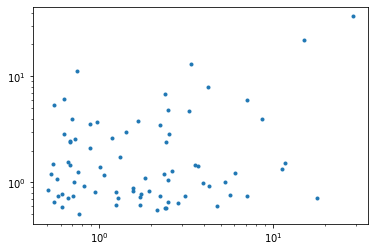

In [242]:
plt.loglog(X[:,:,0].mean(axis=0),X[:,:,1].mean(axis=0),'.');

In [243]:
marker_genes = ['Zic1', 'Neurod1', 'Etv1', 'Nfia', 'Igfbpl1','Prox1']
plot_idx = np.arange(len(fitted_genes))[fitted_genes.isin(marker_genes)]
fitted_genes[plot_idx]

Index(['Prox1', 'Igfbpl1', 'Nfia'], dtype='object')

## Fitting

### Given initial information

ImmGranule1 2460
ImmGranule2 2099
Granule 863


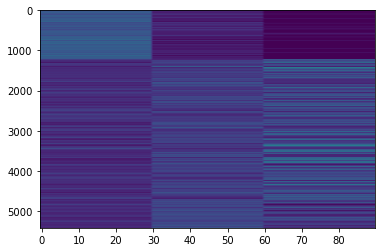

In [244]:
n, p, _ = X.shape
m = 90
Q0 = np.zeros((n,1,m))
for i,celltype in enumerate(cell_types):
    cell_idx = np.where(subdata.obs['ClusterName'].isin([celltype]))[0]
    print(celltype,len(cell_idx))
    Q0[cell_idx,:,i*30:(i+1)*30]=1
Q0 = Q0/np.sum(Q0,axis=0,keepdims=True)
plt.imshow(Q0[:,0],aspect='auto');

In [245]:
topo = np.array([[0,1]])
tau = (0,1,2) # ~24 hours
traj = Trajectory(topo, tau)
Q, elbo = traj.fit(X,Q=Q0,parallel=True,n_threads=2)

run method fit_warm_start


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


In [246]:
traj.compute_AIC(X)

-795.9359937535417

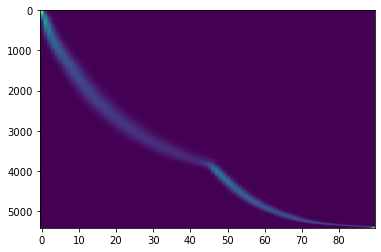

In [206]:
plot_t(Q)

In [248]:
sp.stats.spearmanr(Q[:,0]@traj.t, Q0[:,0]@traj.t)

SpearmanrResult(correlation=0.7365292854155859, pvalue=0.0)

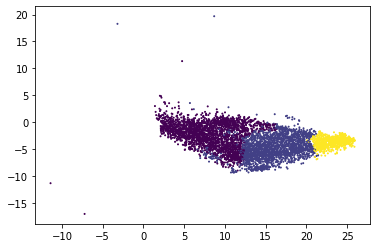

In [274]:
plt.scatter(subdata.obs['TSNE1'],subdata.obs['TSNE2'],c=Q0[:,0]@traj.t,s=1);

In [267]:
plt.scatter(subdata.obs['TSNE1'],subdata.obs['TSNE2'],c=Q[:,0]@traj.t,s=1,cmap='Spectral_r');

SyntaxError: cannot assign to function call (1491763693.py, line 1)

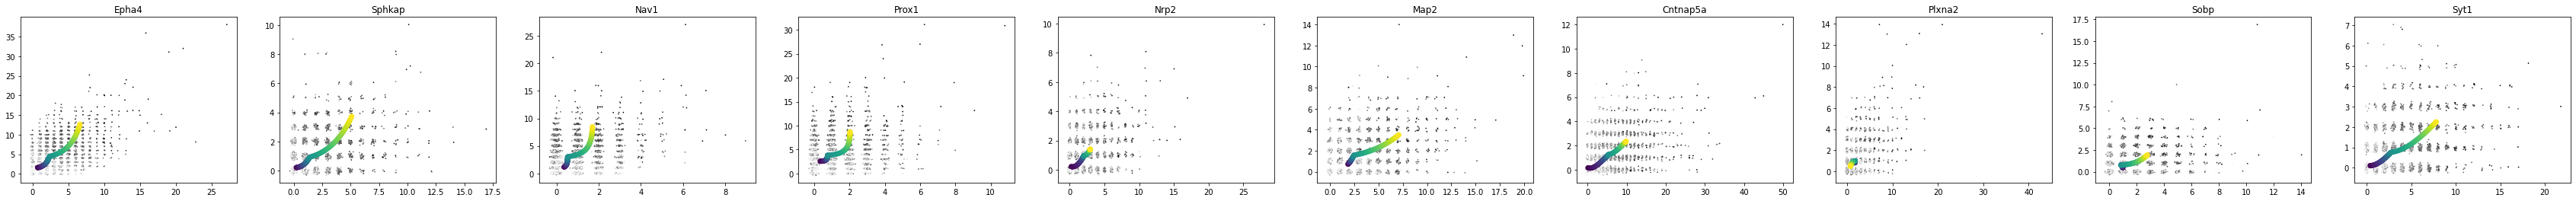

In [210]:
plot_phase(X,Q,traj,idx=np.arange(10),gene_name = fitted_genes)

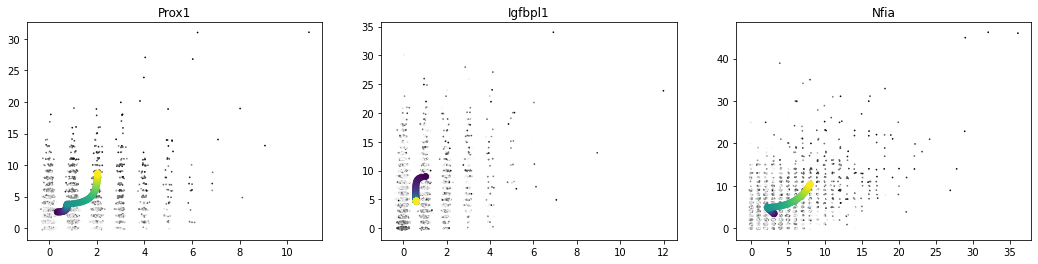

In [211]:
plot_phase(X,Q,traj,idx=plot_idx,gene_name = fitted_genes)

In [270]:
topo = np.array([[0]])
tau = (0,2) 
traj = Trajectory(topo, tau)
Q, elbo = traj.fit(X,Q=Q0,parallel=True,n_threads=2)

run method fit_warm_start


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


In [271]:
traj.compute_AIC(X)

-789.6424337847986

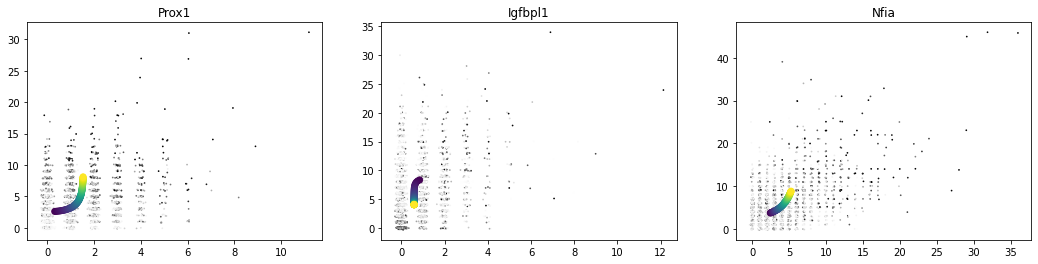

In [272]:
plot_phase(X,Q,traj,idx=plot_idx,gene_name = fitted_genes)

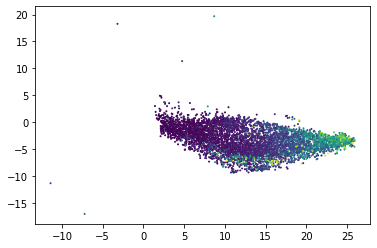

In [273]:
plt.scatter(subdata.obs['TSNE1'],subdata.obs['TSNE2'],c=Q[:,0]@traj.t,s=1);

### Without cluster information

In [253]:
topo = np.array([[0]])
tau = (0,2)
traj = Trajectory(topo, tau)
res = traj.fit(X,m=90,n_init=3,parallel=True,n_threads=4)

run method fit_multi_init
trial 1


100%|██████████| 20/20 [00:08<00:00,  2.40it/s]

trial 2



100%|██████████| 20/20 [00:08<00:00,  2.39it/s]

trial 3



100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


In [254]:
Q, elbo = res


SpearmanrResult(correlation=0.723632124319755, pvalue=0.0)

In [256]:
traj.compute_AIC(X)

-791.030173753786

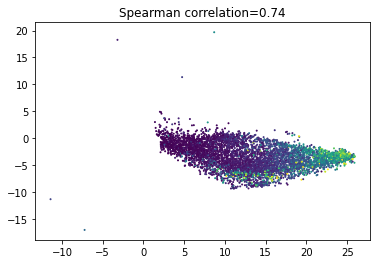

In [283]:
plt.scatter(subdata.obs['TSNE1'],subdata.obs['TSNE2'],c=Q[:,0]@traj.t,s=1);
plt.title("Spearman correlation="+str(np.round(sp.stats.spearmanr(Q[:,0]@traj.t, Q0[:,0]@traj.t)[0],2)));
plt.savefig('../figures/DentateGyrus.png')

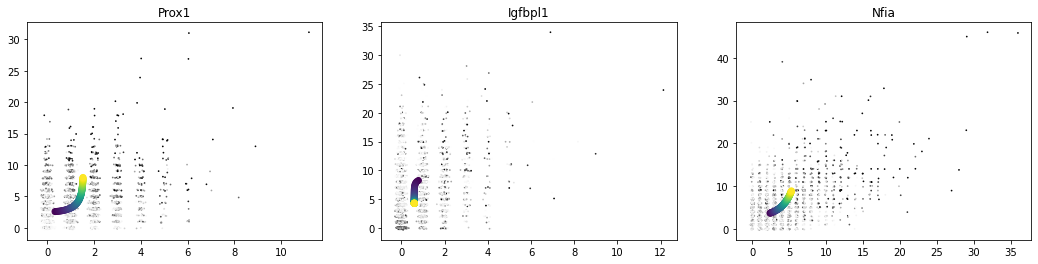

In [258]:
plot_phase(X,Q,traj,idx=plot_idx,gene_name = fitted_genes)

In [259]:
topo = np.array([[0,1]])
tau = (0,1,2)
traj = Trajectory(topo, tau)
res = traj.fit(X,m=90,n_init=3,parallel=True,n_threads=4)

run method fit_multi_init
trial 1


100%|██████████| 20/20 [00:11<00:00,  1.71it/s]

trial 2



100%|██████████| 20/20 [00:12<00:00,  1.64it/s]

trial 3



100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


In [260]:
Q, elbo = res
sp.stats.spearmanr(Q[:,0]@traj.t, Q0[:,0]@traj.t)

SpearmanrResult(correlation=0.17635954766889106, pvalue=3.9697569078657454e-39)

In [261]:
traj.compute_AIC(X)

-812.5571370347508

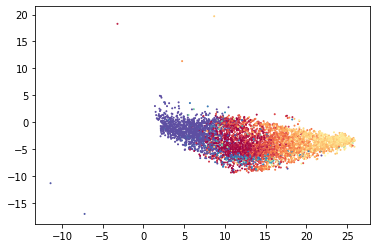

In [269]:
plt.scatter(subdata.obs['TSNE1'],subdata.obs['TSNE2'],c=Q[:,0]@traj.t,s=1,cmap='Spectral_r');